In [ ]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")

print("Path to dataset files:", path)

100%|██████████| 675M/675M [00:31<00:00, 22.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1


In [ ]:
import os

# Corrected path for Windows environment
dataset_dir = '/root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1'

# List all files and directories in the dataset folder
for root, dirs, files in os.walk(dataset_dir):
    print(f"Directory: {root}")

Directory: /root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1
Directory: /root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images
Directory: /root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/cell_images
Directory: /root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/cell_images/Parasitized
Directory: /root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/cell_images/Uninfected
Directory: /root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Parasitized
Directory: /root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Uninfected


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import PIL
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img
from tensorflow.keras.applications.vgg16 import VGG16
import seaborn as sns

from google.colab import drive
drive.mount('/content/mydrive')

Mounted at /content/mydrive


In [ ]:
import pathlib
import random
import shutil
path1 = "/root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/cell_images/Parasitized"
path2 = "/root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/cell_images/Uninfected"

# Define the number of images to select from each folder
num_images = 3750

# Define the combined data directory where selected images will be stored
combined_data_dir = r"/content/drive/MyDrive/Colab Notebooks/malaria_combined_data"
pathlib.Path(combined_data_dir).mkdir(parents=True, exist_ok=True)

# Define paths for the new 'Parasitized' and 'Uninfected' directories inside combined directory
parasitized_dir = pathlib.Path(combined_data_dir) / 'Parasitized'
uninfected_dir = pathlib.Path(combined_data_dir) / 'Uninfected'

# Create the directories if they don't exist
parasitized_dir.mkdir(parents=True, exist_ok=True)
uninfected_dir.mkdir(parents=True, exist_ok=True)

# Get all image files in each directory
parasitized_images = list(pathlib.Path(path1).glob('*'))
uninfected_images = list(pathlib.Path(path2).glob('*'))

# Randomly select 2500 images from each folder
selected_parasitized_images = random.sample(parasitized_images, num_images)
selected_uninfected_images = random.sample(uninfected_images, num_images)

# Combine the selected images
combined_images = selected_parasitized_images + selected_uninfected_images

# Shuffle the combined list
random.shuffle(combined_images)

# Move the shuffled images to the new directory
for img_file in combined_images:
    if img_file in selected_parasitized_images:
        shutil.copy(img_file, parasitized_dir / img_file.name)
    else:
        shutil.copy(img_file, uninfected_dir / img_file.name)

print(f"Images have been combined and shuffled. The combined dataset is saved to: {combined_data_dir}")

Images have been combined and shuffled. The combined dataset is saved to: /content/drive/MyDrive/Colab Notebooks/malaria_combined_data


In [ ]:
img_width = 224
img_height = 224
batch_size = 32

# ImageDataGenerator for training data (with augmentation)
train_image_gen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, # Define the validation split
    validation_split=0.2,
)

# ImageDataGenerator for validation data (without augmentation)
val_image_gen = ImageDataGenerator(
    rescale=1/255,  # Only normalize the images
    validation_split=0.2
)

# Create the flow from directory for training
train_data = train_image_gen.flow_from_directory(
    combined_data_dir,  # Directory with images
    subset="training",  # Specify that this is the training data
    class_mode="binary",  # Binary classification
    target_size=(img_width, img_height),  # Resize images
    batch_size=batch_size,  # Set the batch size
    shuffle=True,  # Shuffle the training data
    color_mode='rgb'
)

# Create the flow from directory for validation
val_data = val_image_gen.flow_from_directory(
    combined_data_dir,  # Directory with images
    subset="validation",  # Specify that this is the validation data
    class_mode="binary",  # Binary classification
    target_size=(img_width, img_height),  # Resize images
    batch_size=batch_size,  # Set the batch size
    shuffle=False,  # No need to shuffle the validation data
    color_mode='rgb'
)



Found 6000 images belonging to 2 classes.
Found 1499 images belonging to 2 classes.


In [ ]:
print(train_data.class_indices)

{'Parasitized': 0, 'Uninfected': 1}


In [ ]:
input = Input(shape=(img_width, img_height, 3), dtype='float32', name='malaria_cells')

# Convolutional Layer 1
X = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', dilation_rate=(1, 1), groups = 1)(input)
X = BatchNormalization(axis = 3)(X)
X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)

# Convolutional Layer 2
X = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', dilation_rate=(1, 1), groups = 1)(X)
X = BatchNormalization(axis = 3)(X)
X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)

# Convolutional Layer 3
X = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(X)
X = BatchNormalization()(X)
X = MaxPooling2D(pool_size=(2, 2))(X)

# Global Average Pooling
X = GlobalAveragePooling2D()(X)

# Fully Connected Layers
X = Dense(256, activation='relu')(X)
X = Dropout(0.5)(X)
X = Dense(128, activation='relu')(X)
X = Dropout(0.3)(X)

output = Dense(1, activation='sigmoid', name='cell_classes')(X)

model = Model(inputs=input, outputs=output)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ malaria_cells (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cell_classes (Dense)                 │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 160,193 (625.75 KB)

 Trainable params: 159,745 (624.00 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=0.0005)
loss = tf.keras.losses.BinaryCrossentropy()
epochs = 5

model.compile(optimizer=optim, loss=loss, metrics=["accuracy"])

In [ ]:
# Ensure the model trains on GPU if available
with tf.device('/GPU:0'):  # Use GPU if available
    history = model.fit(
        train_data,         # The training data
        epochs=epochs,         # Number of epochs to train
        validation_data=val_data  # Validation data to evaluate during training
    )

Epoch 1/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 91s 425ms/step - accuracy: 0.6333 - loss: 0.6490 - val_accuracy: 0.5003 - val_loss: 0.9296
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 78s 398ms/step - accuracy: 0.8008 - loss: 0.4549 - val_accuracy: 0.5010 - val_loss: 1.7675
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.8754 - loss: 0.3336 - val_accuracy: 0.6498 - val_loss: 0.7282
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 85s 412ms/step - accuracy: 0.9095 - loss: 0.2652 - val_accuracy: 0.8065 - val_loss: 0.4473
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 77s 391ms/step - accuracy: 0.9230 - loss: 0.2491 - val_accuracy: 0.9333 - val_loss: 0.2335


In [ ]:
model.save("/content/mydrive/My Drive/Colab Notebooks/output/malaria/malaria-cnn-v3.keras")

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict on the validation data
predictions = model.predict(val_data)
predicted_classes = (predictions > 0.5).astype("int32")  # Convert probabilities to class labels (0 or 1)

# Get the true labels
true_labels = val_data.classes  # Actual labels from the validation data

# Print the classification report
print(classification_report(true_labels, predicted_classes, target_names=val_data.class_indices.keys()))

47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step
              precision    recall  f1-score   support

 Parasitized       0.97      0.89      0.93       749
  Uninfected       0.90      0.97      0.94       750

    accuracy                           0.93      1499
   macro avg       0.94      0.93      0.93      1499
weighted avg       0.94      0.93      0.93      1499



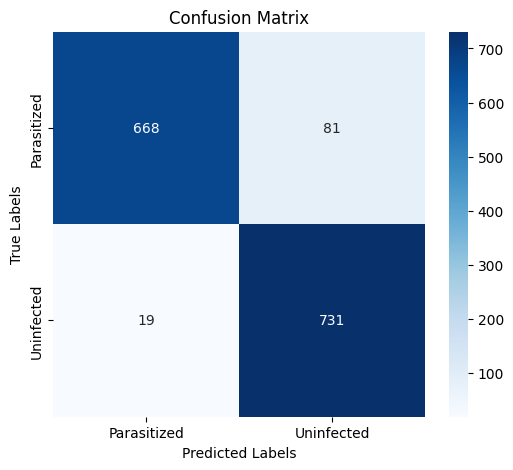

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_data.class_indices.keys(), yticklabels=val_data.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

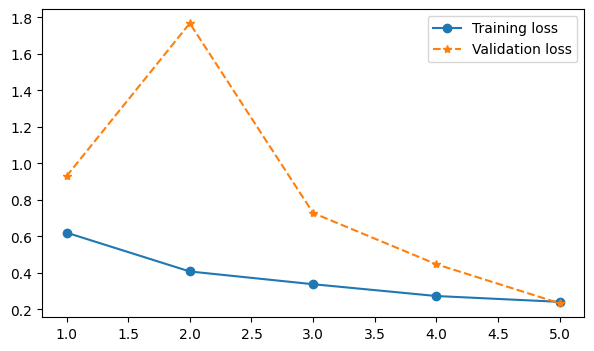

In [ ]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
ax.plot(range(1, epochs+1), history.history["loss"], marker="o", label="Training loss")
ax.plot(range(1, epochs+1), history.history["val_loss"], marker="*", ls="--", label="Validation loss")
ax.legend()
plt.show()

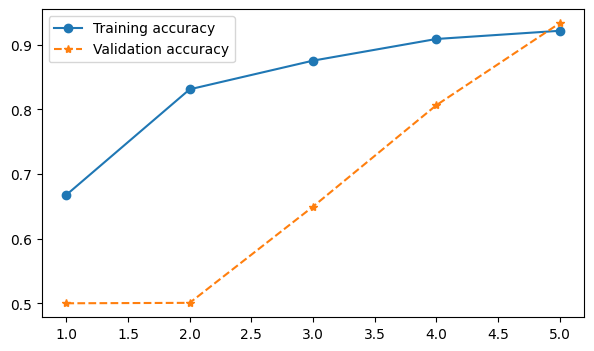

In [ ]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
ax.plot(range(1, epochs+1), history.history["accuracy"], marker="o", label="Training accuracy")
ax.plot(range(1, epochs+1), history.history["val_accuracy"], marker="*", ls="--", label="Validation accuracy")
ax.legend()
plt.show()

XAI approach: Grad-CAM

In [ ]:
from tensorflow.keras.models import load_model
import cv2

In [ ]:
# Load keras model

with tf.device('/GPU:0'):  # Use GPU if available
    model = load_model("/content/mydrive/My Drive/Colab Notebooks/output/malaria/malaria-cnn-v3.keras")

    # Make predictions using the model
    predictions_xai = model.predict(val_data)
    predicted_classes_xai = (predictions_xai > 0.5).astype("int32")
    labels = val_data.labels

    # Calculate accuracy
    accuracy = (predicted_classes_xai.flatten() == labels.flatten()).sum() / len(labels)
    print(f"Batch accuracy: {accuracy:.4f}")

    # Create comparison DataFrame for inspection
    comparison = pd.DataFrame({"Actual": labels.flatten(), "Prediction": predicted_classes_xai.flatten()})

comparison

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step
Batch accuracy: 0.9333


,Actual,Prediction
0,0,0
1,0,0
2,0,0
3,0,1
4,0,0
...,...,...
1494,1,1
1495,1,1
1496,1,1
1497,1,1


In [ ]:
def generate_gradcam(model, img_array, layer_name):

    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class with respect to the output feature map
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        print("Raw Prediction Probability:", predictions.numpy()[0][0])
        predicted_class = tf.argmax(predictions[0])
        loss = predictions[:, predicted_class]

    if predictions.numpy()[0][0] >= 0.5:  # Default threshold for binary classification
        predicted_class = 1  # Uninfected
        print("Predicted Class: Uninfected")
    else:
        predicted_class = 0  # Parasitized
        print("Predicted Class: Parasitized")

    grads = tape.gradient(loss, conv_outputs)

    # Compute the guided gradients and the weights
    guided_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Compute the Grad-CAM output
    conv_outputs = conv_outputs[0]
    gradcam = tf.reduce_sum(tf.multiply(guided_grads, conv_outputs), axis=-1)

    gradcam = tf.maximum(gradcam, 0) / tf.math.reduce_max(gradcam)
    gradcam = gradcam / tf.reduce_max(gradcam)  # Normalize to [0, 1]

    return gradcam.numpy()


In [ ]:
# Function to overlay Grad-CAM on the original image
def overlay_gradcam(original_img, gradcam, alpha=0.5):
    # Resize the Grad-CAM heatmap to match the original image size
    heatmap = cv2.resize(gradcam, (original_img.shape[1], original_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # Scale heatmap to 0-255

    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    red_channel = heatmap[:, :, 2]                         # Extract red channel (hotspots)

    # Create a mask for the red regions (non-zero activations)
    mask = (red_channel > 50).astype(np.uint8)  # Threshold to keep only strong activations
    mask = cv2.merge([mask * 255] * 3)          # Convert mask to 3 channels for blending

    # Ensure original image is in RGB and uint8 format
    if original_img.max() <= 1.0:
        original_img = (original_img * 255).astype(np.uint8)
    if len(original_img.shape) == 2:  # If grayscale, convert to RGB
        original_img = cv2.cvtColor(original_img, cv2.COLOR_GRAY2RGB)

    # Blend the red Grad-CAM heatmap with the original image
    overlayed_img = cv2.addWeighted(original_img, 1 - alpha, heatmap, alpha, 0)
    return overlayed_img


In [ ]:
sample_img, _ = next(train_data)
_

array([1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0.],
      dtype=float32)

Raw Prediction Probability: 0.004390933
Predicted Class: Parasitized


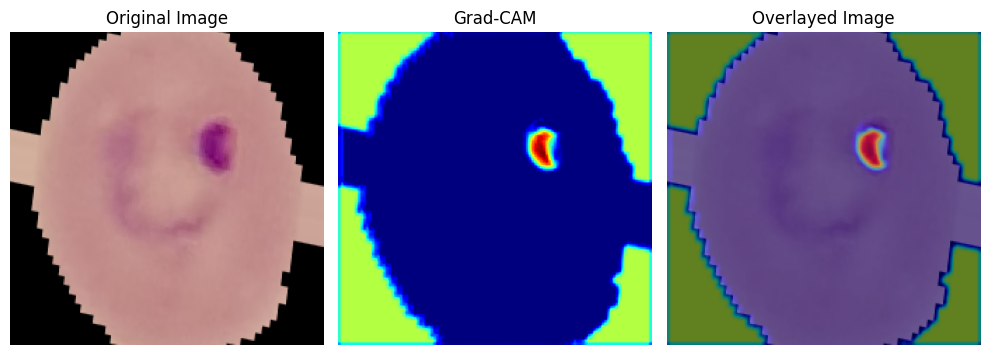

In [ ]:
original_img = sample_img[1]

img_array = np.expand_dims(original_img, axis=0)

layer_name = "conv2d_8"      # this layer wil provide the most accurate gradcam after testing
gradcam = generate_gradcam(model, img_array, layer_name)

original_img_uint8 = (original_img * 255).astype(np.uint8)  # Convert to uint8 for visualization
overlayed_img = overlay_gradcam(original_img_uint8, gradcam)

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(original_img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(gradcam, cmap="jet")
plt.title("Grad-CAM")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlayed_img)
plt.title("Overlayed Image")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# Loop through all images in the dataset batch
for i, original_img in enumerate(sample_img):  # Iterate over each image in the batch
    print(f"Processing image {i + 1}/{len(sample_img)}")

    img_array = np.expand_dims(original_img, axis=0)

    # this layer wil provide the most accurate gradcam after testing
    layer_name = "conv2d_8"
    gradcam = generate_gradcam(model, img_array, layer_name)

    original_img_uint8 = (original_img * 255).astype(np.uint8)  # Ensure uint8 format
    overlayed_img = overlay_gradcam(original_img_uint8, gradcam)

    # Plot the results
    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis("off")

    # Grad-CAM
    plt.subplot(1, 3, 2)
    plt.imshow(gradcam, cmap="jet")
    plt.title("Grad-CAM")
    plt.axis("off")

    # Overlayed Image
    plt.subplot(1, 3, 3)
    plt.imshow(overlayed_img)
    plt.title("Overlayed Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.